<a href="https://colab.research.google.com/github/openecometrics/un_datathon_2023/blob/main/compute_animal_abundances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install pandas folium pygbif geopandas tesspy shapely numpy seaborn

### Plan
 - Select key organisms for abundance tracking
 - Get tessellation of the Olympic Peninsula
 - Compute abundance of each organism in each tile for each year requested
   - Abundance: Number of observations of that organism divided by the total number of observations of all organisms in that tile. This should somewhat counteract the effect of more observations of a given organism correlating with the number of people who are out making entries in iNaturalist.
 - Normalize the abundance of each organism by its highest abundance level in the dataset
   - Because some organisms are rarer than othes, they will naturally have lower abunance. If we naively sum all of the abundances together, we will in effect be discounting the rarer organisms. Normalize them to avoid this.
 - Sum all normalized abundances to get overall biodiversity score.

In [52]:
import pandas as pd
import folium
from folium import Choropleth
from pygbif import occurrences as occ
import geopandas as gpd
from tesspy import Tessellation
from shapely.geometry import shape
import json
import numpy as np
import seaborn as sns

In [53]:
rerun_calculations = False

In [54]:
organism_ids = {
    'order':{
        'butterflies_and_moths':797,
    },
    'family':{
        'bees':4334,
    },
    'genus':{
        'salmon':2351426,
        'bear':2433406,
        'mountain_lion':2435098,
    },
    'species':{
        'spotted_owl': 2497487,
        'marbled_murrelet':5229281,
        'tailed_frog':2429804,
        'wolf':5219173,
    }
}

In [55]:
western_wa = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -124.64249826799414,
              48.394721117228386
            ],
            [
              -124.74789105314187,
              48.05878497143041
            ],
            [
              -124.42635567803364,
              47.737166647966376
            ],
            [
              -124.21855468613654,
              47.18559767340889
            ],
            [
              -124.06715205761054,
              46.28963145189286
            ],
            [
              -123.376753572339,
              46.25370422530523
            ],
            [
              -122.89495705565514,
              46.10914768201141
            ],
            [
              -122.67802967231282,
              45.80140543311418
            ],
            [
              -121.6505906546152,
              45.721523425238786
            ],
            [
              -120.63031096656965,
              45.736683463679555
            ],
            [
              -120.79091615347079,
              46.202146904425234
            ],
            [
              -120.72992899713898,
              46.63182940613564
            ],
            [
              -120.54436276955366,
              46.971811552223045
            ],
            [
              -120.43484667264883,
              47.41892199116026
            ],
            [
              -120.17078989691527,
              47.75705064822779
            ],
            [
              -119.54731727199803,
              48.162211056890925
            ],
            [
              -119.53684321799557,
              48.972490202421824
            ],
            [
              -122.73536050744093,
              49.01325268974662
            ],
            [
              -122.97069831630657,
              48.79311305094106
            ],
            [
              -123.20333889167694,
              48.64012333911748
            ],
            [
              -123.04604630459414,
              48.40995245868163
            ],
            [
              -123.09088856665545,
              48.132754133670744
            ],
            [
              -123.47680367465023,
              48.133034896479984
            ],
            [
              -124.02067908283038,
              48.1792374356624
            ],
            [
              -124.64249826799414,
              48.394721117228386
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

olympic_peninsula = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -124.17205778216527,
              47.02617882285358
            ],
            [
              -123.92644829744015,
              46.957933526629006
            ],
            [
              -123.7120290884385,
              46.98175326150019
            ],
            [
              -123.33483229736751,
              47.045413114869945
            ],
            [
              -123.02975977754974,
              47.11192876341008
            ],
            [
              -123.04901912397163,
              47.16882896373423
            ],
            [
              -123.12075612169724,
              47.30722110165354
            ],
            [
              -123.13565861022067,
              47.379940677294
            ],
            [
              -123.08167061174507,
              47.46049063772071
            ],
            [
              -123.01513285815503,
              47.545862086825
            ],
            [
              -122.93953239975441,
              47.617477711850995
            ],
            [
              -122.85177390959755,
              47.65927295923149
            ],
            [
              -122.77702625414544,
              47.671515338515746
            ],
            [
              -122.7551292349215,
              47.73943153189197
            ],
            [
              -122.71201699525136,
              47.78796080239309
            ],
            [
              -122.61220415038645,
              47.86613789125323
            ],
            [
              -122.61215460104998,
              47.96852460792425
            ],
            [
              -122.68322693459334,
              48.10497972345962
            ],
            [
              -122.77457032310164,
              48.154893819759934
            ],
            [
              -123.1241744030956,
              48.17497032207092
            ],
            [
              -123.24814799981637,
              48.12883905863259
            ],
            [
              -123.35658316740675,
              48.13117436395419
            ],
            [
              -123.66480359494734,
              48.17686606203094
            ],
            [
              -124.01046372158311,
              48.17603591532165
            ],
            [
              -124.27392781988748,
              48.26704517244747
            ],
            [
              -124.55437626661077,
              48.37877259896911
            ],
            [
              -124.71263742890997,
              48.400940123766276
            ],
            [
              -124.74158451363445,
              48.37735468940957
            ],
            [
              -124.66565972178253,
              48.32574628353177
            ],
            [
              -124.69772810089239,
              48.25123771604518
            ],
            [
              -124.74093388051381,
              48.176863165486054
            ],
            [
              -124.68692665598715,
              47.99888705718854
            ],
            [
              -124.64372087636576,
              47.885528286332715
            ],
            [
              -124.50330209259587,
              47.813041630350455
            ],
            [
              -124.42409149662338,
              47.7065445767341
            ],
            [
              -124.35928282719149,
              47.52937529012837
            ],
            [
              -124.34848138228581,
              47.41011663997355
            ],
            [
              -124.28367271285391,
              47.324766186173974
            ],
            [
              -124.20806259851636,
              47.178129751818375
            ],
            [
              -124.17205778216527,
              47.02617882285358
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [56]:
gdf = gpd.GeoDataFrame.from_features(olympic_peninsula)
gdf = gdf.set_crs("WGS84")
gdf['osm_id']=None #Need to do this for the code to work
opt = Tessellation(gdf)
opt_squares = opt.squares(resolution=10)
opt_squares = json.loads(opt_squares.to_json())

In [57]:
def get_all_observations(year, month, lat_low, lat_up, long_low, long_up, limit=None):
    df = []
    num = 300
    i=0
    while num==300:
        if limit is not None and i>limit:
            break
        print("Occurrence", i*300)
        res = occ.search(
            datasetKey="50c9509d-22c7-4a22-a47d-8c48425ef4a7",
            decimalLatitude=f"{lat_low},{lat_up}",
            decimalLongitude=f"{long_low},{long_up}",
            year=year,
            month=month,
            offset=300*i)
        num = len(res['results'])
        df.append(pd.DataFrame(res['results']))
        i+=1
    return pd.concat(df)

In [58]:
def compute_abundances_for_year(year, limit=10):
    dfd = {'polygon':[], 'all_obs':[], 'year':[]}
    for taxon, species in organism_ids.items():
        for species_name, id in species.items():
            dfd[species_name+"_obs"] = []
    i=0
    for feat in opt_squares['features']:
        print("tile", i)
        poly = feat['geometry']
        long_low, lat_low = np.array(poly['coordinates']).min(axis=1)[0]
        long_up, lat_up = np.array(poly['coordinates']).max(axis=1)[0]
        dfd['polygon'].append(poly)
        print("All observations")
        all_obs = get_all_observations(year, None, lat_low, lat_up, long_low, long_up, limit=limit)
        n_obs = all_obs.shape[0]
        if n_obs==0:
            for key, val in organism_ids.items():
                for key2, val2 in val.items():
                    print(key2)
                    dfd[key2+"_obs"].append(0)
        else:
            for key, val in organism_ids.items():
                for key2, val2 in val.items():
                    print(key2)
                    # dfd[key2+"_obs"].append(count_taxon_observations(val2, year, month, lat_low, lat_up, long_low, long_up))
                    if key=='order':
                        dfd[key2+"_obs"].append(np.sum(all_obs['orderKey']==val2))
                    elif key=='family':
                        dfd[key2+"_obs"].append(np.sum(all_obs['familyKey']==val2))
                    elif key=='genus':
                        dfd[key2+"_obs"].append(np.sum(all_obs['genusKey']==val2))
                    elif key=='species':
                        dfd[key2+"_obs"].append(np.sum(all_obs['speciesKey']==val2))
        dfd['all_obs'].append(n_obs)
        dfd['year'].append(year)
        i+=1
        print('\n')
    return pd.DataFrame(dfd)

In [59]:
gdfs = []
years = [2004, 2009, 2014, 2019, 2020, 2021, 2022]
if rerun_calculations:
  for year in years:
      df = compute_abundances_for_year(year)
      geom = [shape(i) for i in df['polygon']]
      gdf = gpd.GeoDataFrame(df)
      gdf['geometry'] = geom
      gdf.drop(columns=['polygon'], inplace=True)
      gdf.to_file(f"animal_abundances_{year}.geojson", driver='GeoJSON')
      gdfs.append(gdf)

In [60]:
gdfs=[]
for year in years:
    gdfs.append(gpd.read_file(f"animal_abundances_{year}.geojson", driver='GeoJSON'))

In [61]:
for g in gdfs:
    for key, val in organism_ids.items():
        for key2, val2 in val.items():
            g[key2+'_abundance'] = g[key2+'_obs']/g['all_obs']

In [62]:
big_gdf = pd.concat(gdfs)

In [63]:
max_abundances = big_gdf[big_gdf.columns[big_gdf.columns.str.contains("_abundance")]].max()

In [64]:
for g in gdfs:
    for key, val in organism_ids.items():
        for key2, val2 in val.items():
            if max_abundances[key2+'_abundance']>0:
                g[key2+'_abundance'] /= max_abundances[key2+'_abundance']

In [65]:
for g in gdfs:
    g['total_abundance'] = 0
    for key, val in organism_ids.items():
        for key2, val2 in val.items():
            g['total_abundance'] += g[key2+'_abundance']

Make a Choropleth map of the animal abundances in each tile of Western Washington.

In [66]:
m_6 = folium.Map(location=[47.649942,-122.335898], tiles='cartodbpositron', zoom_start=8)

Choropleth(geo_data=gdfs[0].__geo_interface__,
           data=gdfs[6]['bear_abundance'],
           key_on="feature.id",
           fill_color='YlGnBu',
           legend_name='Black Bear Abundance',
           fill_opacity=0.5,
          ).add_to(m_6)

m_6

In [67]:
big_gdf = pd.concat(gdfs).drop(columns=['geometry'])

In [68]:
max_abundances.index = max_abundances.index.str.replace("_abundance","")

In [69]:
annual = big_gdf.groupby(by='year').sum()
for key, val in organism_ids.items():
    for key2, val2 in val.items():
        annual[key2+'_abundance'] = annual[key2+'_obs']/annual['all_obs']

d1 = annual.reset_index().melt(id_vars=['year'], value_vars=annual.columns[annual.columns.str.contains('abundance')], var_name='taxon', value_name='abundance')
d1['taxon'] = d1['taxon'].str.replace("_abundance", "")
d2 = annual.reset_index().melt(id_vars=['year'], value_vars=annual.columns[annual.columns.str.contains('obs')], var_name='taxon', value_name='observations')
d2['taxon'] = d2['taxon'].str.replace("_obs", "")
annual = d1.merge(right=d2, on=['year', 'taxon'])
annual = annual.merge(annual.groupby(by='taxon').max()['abundance'], on='taxon')
annual['abundance'] = annual['abundance_x']/annual['abundance_y']
annual.drop(columns=['abundance_x','abundance_y'], inplace=True)

In [70]:
annual

,year,taxon,observations,abundance
0,2004,butterflies_and_moths,0,0.000000
1,2009,butterflies_and_moths,4,0.138563
2,2014,butterflies_and_moths,55,0.485795
3,2019,butterflies_and_moths,671,0.587987
4,2020,butterflies_and_moths,1327,0.951731
...,...,...,...,...
58,2014,wolf,0,0.000000
59,2019,wolf,0,0.000000
60,2020,wolf,0,0.000000
61,2021,wolf,0,0.000000


In [71]:
grouped = annual.groupby(by=['year']).sum(numeric_only=True)['abundance']
annual = pd.concat((annual, pd.DataFrame({'abundance': grouped, 'taxon':np.repeat('total', len(grouped)), 'observations':[np.nan for i in range(len(grouped))]}).reset_index()))

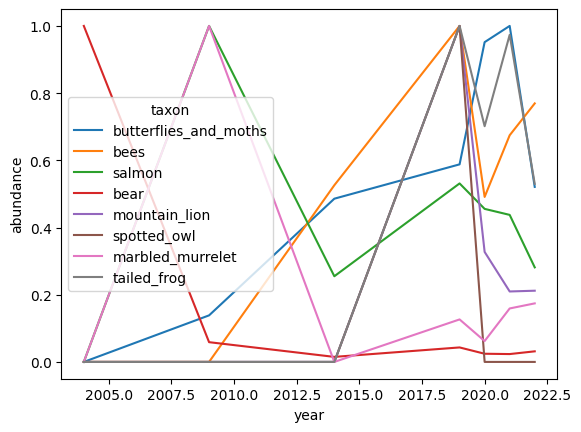

In [72]:
ax = sns.lineplot(data=annual[(annual['taxon']!='wolf')&(annual['taxon']!='total')], x='year', y='abundance', hue='taxon')

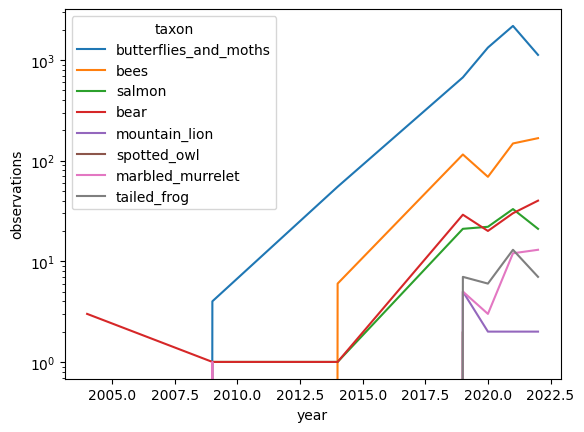

In [73]:
ax = sns.lineplot(data=annual[(annual['taxon']!='wolf')&(annual['taxon']!='total')], x='year', y='observations', hue='taxon')
ax.set_yscale('log')